Para el desarrollo de este ejercicio se pide lo siguiente:

    Desarrollar un sistema de recomendación de peliculas basado en la información proporcionada.
    Realizar un analisis y descripción de la información presentada utilizando herramientas de aprendizaje no supervisado. ¿Qué puede decir de los datos y su distribución?, ¿qué grupos pueden encontrar?, ¿qué indican esos grupos?, etc...

¿Qué se debe entregar?

    Analisis de la información presentada. ¿Qué se puede inferir de los datos?
    Implementación y explicación del sistema de recomendación. Análisis de los resultados del sistema de recomendación utilizando un ejemplo.
    ¿Cómo puedo evaluar que peliculas le podrian gustar a un usuario nuevo (que no este en la base de datos) basado en las calificaciones que este da a una serie de peliculas?
    Análisis sobre como incorporar toda la información otorgada.
    ¿Qué se puede inferir sobre los diferentes usuarios y sus gustos en peliculas? se puede encontrar alguna relación entre edad, profesión, sexo y genero de peliculas que les gusta a estos grupos? ¿Cómo se podria obtener esta información?
    Durante el desarrollo de cada uno de los puntos del taller indique los métodos utilizados y explique la forma como los utiliza.
    Una discusión sobre el desarrollo del proyecto, los metodos utilizados, posibles mejoras, etc..


## Sistema de recomendación

Hoy en día, la gran cantidad de entretenimiento disponible al 

### Factorización No negativa de Matrices 

Para el presente trabajo, se usará la factorización no negativa de matrices o NMF, por sus siglas en inglés, para diseñar un sistema de recomendación de películas a un grupo de usuarios, basándose en las calificaciones dadas a películas previament vistas. 

NMF es un algoritmo de descomposición matricial que asume que los datos y los componentes en los que se descompondrán no son negativos. Este pre-requisito y propiedad, lo hace un excelente candidato para la creación de sistemas de recomendación de canciones, películas, videojuegos, productos, etc. Pues es de uso común que las calificaciones sean únicamente valores de escalas positivas, de 0 a 10. de 0 a 5, etc. Pues permiten una interpretación sencilla y clara de los datos: Un usuario puntuando 10 o 9 indica que el producto o contenido es de su preferencia, 6-5 que es un contenido mediocre y 1-2 que el contenido no es de su gusto. 

Esto permite que puedan encontrarse patrones o perfiles mayoritarios donde basándose en los ratings dados y partiendo de ellos, se puedan crear recomendaciones a los usuarios de elementos que no hayan consumido o descubierto aún, dada la ya mencionada dificultad de consumir todo el contenido disponible en una plataforma o todos los productos de un lugar en concreto. 

NMF logra eso a través de la aproximación a la matriz original, pues al no ser una reconstrucción perfecta, permite llenar o descubrir que tanto podría un usuario de un sitio en especifíco o consumidor de un producto favorecer o gustarle un determinado elemento que no haya probado o consumido antes, gracias a la aproximación de la matriz que permite llenar esos valores basándose en perfiles similares encontrados internamente en la descomposición de la matriz. 

NMF funciona de la siguiente manera: 

$$
V = W \cdot H
$$

Donde 
* V es la matriz original de tamaño nxm
* W es la matriz de descomposición de V de n filas por k columnas, donde k es la cantidad de componentes en que se descompondra V
* W es la matriz de descomposición de V de m columnas por k filas, donde k es la cantidad de componentes en que se descompondra V

De estas matrices descompuestas, se puede recrear $\hat V$ a través del producto punto matricial, lo que dará lugar a la aproximación permitiendo estimar valores para aquellas celdas donde no se encontrarán antes. Esto, permite establece el sistema de recomendación en base a que tan similar será un usuario a otro respecto a los valores colocados en los mismos objetos. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse 

### Carga de datos

In [3]:
data_ratings = pd.read_excel('./data/u_data_ratings.xls')
movie_genre =pd.read_excel('./data/u_movies_genre.xls', header=None, names=['init'])
movie_items = pd.read_excel('./data/u_movies_items.xls',header=None, names=['init'])
occupation = pd.read_excel('./data/u_occupation.xls',header=None, names=['occupation'])
user_info = pd.read_excel('./data/u_user_info.xls',header=None, names=['init'])

### Un Vistazo  a los datos

In [4]:
data_ratings.rename(columns={'Unnamed: 3':'Timestamp'},inplace=True)
data_ratings['Timestamp'] = pd.to_datetime(data_ratings['Timestamp'], unit='s')
data_ratings.head(10)

,User ID,Item ID,Rating,Timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
5,298,474,4,1998-01-07 14:20:06
6,115,265,2,1997-12-03 17:51:28
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53


In [5]:
# Formateo de los datos de movie_genre
movie_genre[['genre','id']] = movie_genre['init'].str.split('|', expand=True)
movie_genre = movie_genre.drop(columns=['init'])
movie_genre

,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [6]:
# Formateo de los datos de movie_itms
movie_items[['Item ID','movie_name','release_date','video_release_date','imdb_url',"unknown", "Action", "Adventure", "Animation", "Children's",
             "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]] = movie_items['init'].str.split('|', expand=True)

movie_items = movie_items.drop(columns=['init'])
movie_items[['Item ID']+movie_items.columns[5:].to_list()] = movie_items[['Item ID']+movie_items.columns[5:].to_list()].apply(pd.to_numeric)
#movie_items['Item ID'] = pd.to_numeric(movie_items['Item ID'])
print(movie_items)

      Item ID                                 movie_name release_date  \
0           1                           Toy Story (1995)  01-Jan-1995   
1           2                           GoldenEye (1995)  01-Jan-1995   
2           3                          Four Rooms (1995)  01-Jan-1995   
3           4                          Get Shorty (1995)  01-Jan-1995   
4           5                             Copycat (1995)  01-Jan-1995   
...       ...                                        ...          ...   
1677     1678                          Mat' i syn (1997)  06-Feb-1998   
1678     1679                           B. Monkey (1998)  06-Feb-1998   
1679     1680                       Sliding Doors (1998)  01-Jan-1998   
1680     1681                        You So Crazy (1994)  01-Jan-1994   
1681     1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

     video_release_date                                           imdb_url  \
0                        http://us.imdb.com/M

In [7]:
movie_items.columns[5:].to_list()

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [8]:
movie_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Item ID             1682 non-null   int64 
 1   movie_name          1682 non-null   object
 2   release_date        1682 non-null   object
 3   video_release_date  1682 non-null   object
 4   imdb_url            1682 non-null   object
 5   unknown             1682 non-null   int64 
 6   Action              1682 non-null   int64 
 7   Adventure           1682 non-null   int64 
 8   Animation           1682 non-null   int64 
 9   Children's          1682 non-null   int64 
 10  Comedy              1682 non-null   int64 
 11  Crime               1682 non-null   int64 
 12  Documentary         1682 non-null   int64 
 13  Drama               1682 non-null   int64 
 14  Fantasy             1682 non-null   int64 
 15  Film-Noir           1682 non-null   int64 
 16  Horror              1682

In [9]:
occupation

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer
5,entertainment
6,executive
7,healthcare
8,homemaker
9,lawyer


In [10]:
user_info[['User ID','age','gender','occupation','zip_code']] = user_info['init'].str.split('|', expand=True)
user_info = user_info.drop(columns=['init'])
user_info['User ID'] = pd.to_numeric(user_info['User ID'])
user_info['age'] = pd.to_numeric(user_info['age'])
user_info.head(10)

,User ID,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


### Analisis de datos 

### Data Ratings

In [52]:
data_ratings.describe()

,User ID,Item ID,Rating,Timestamp
count,65535.000000,65535.000000,65535.000000,65535
mean,367.034043,426.078508,3.533883,1997-12-30 21:18:03.777614848
min,1.000000,1.000000,1.000000,1997-09-20 03:05:10
25%,194.000000,174.000000,3.000000,1997-11-13 19:17:28.500000
50%,345.000000,322.000000,4.000000,1997-12-23 20:56:19
75%,526.000000,634.000000,4.000000,1998-02-23 00:19:36
max,921.000000,1669.000000,5.000000,1998-04-22 23:10:38
std,222.393136,330.886130,1.130528,NaN


In [87]:
data_ratings['Rating'].value_counts()

Rating
4    22452
3    17652
5    14038
2     7246
1     4147
Name: count, dtype: int64

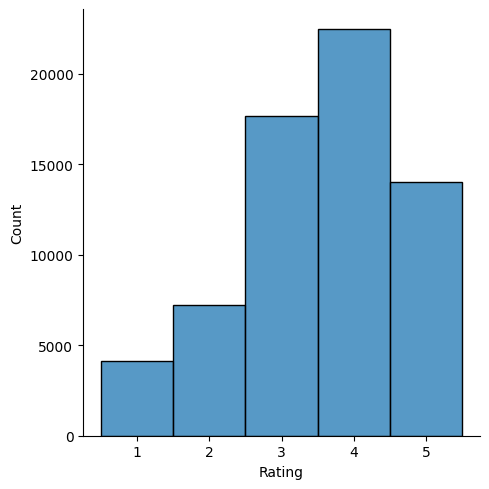

In [88]:
sns.displot(data=data_ratings,x='Rating', discrete=True)

In [67]:
movies_rating = pd.merge(data_ratings, movie_items[['Item ID','movie_name']], how='left', on='Item ID' )
movies_rating.head()

,User ID,Item ID,Rating,Timestamp,movie_name
0,196,242,3,1997-12-04 15:55:49,Kolya (1996)
1,186,302,3,1998-04-04 19:22:22,L.A. Confidential (1997)
2,22,377,1,1997-11-07 07:18:36,Heavyweights (1994)
3,244,51,2,1997-11-27 05:02:03,Legends of the Fall (1994)
4,166,346,1,1998-02-02 05:33:16,Jackie Brown (1997)


In [19]:
movies_rating.movie_name.value_counts()

movie_name
Star Wars (1977)              386
Contact (1997)                341
Fargo (1996)                  332
Scream (1996)                 329
Return of the Jedi (1983)     326
                             ... 
MURDER and murder (1996)        1
Homage (1995)                   1
Every Other Weekend (1990)      1
Hunted, The (1995)              1
Low Life, The (1994)            1
Name: count, Length: 1611, dtype: int64

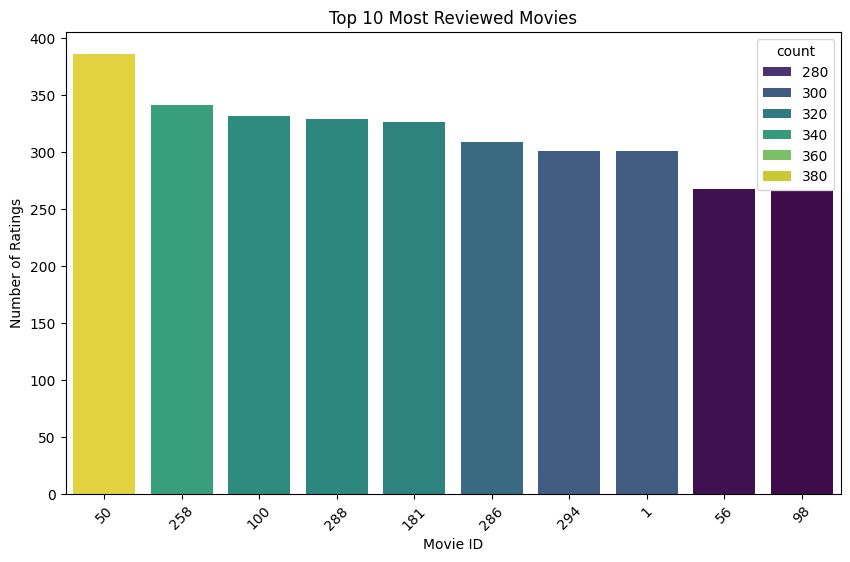

In [66]:
#a = movies_rating.groupby("movie_name")['Rating'].count().reset_index(name='count')
a = data_ratings.groupby('Item ID')['Rating'].count().reset_index(name='count')
top_10 = a.sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
#sns.barplot(x='movie_name', y='count', data=top_10, palette='viridis',hue='movie_name', legend=False)
sns.barplot(x='Item ID', y='count', data=top_10, hue='count', order=top_10['Item ID'], palette='viridis')
plt.title('Top 10 Most Reviewed Movies')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

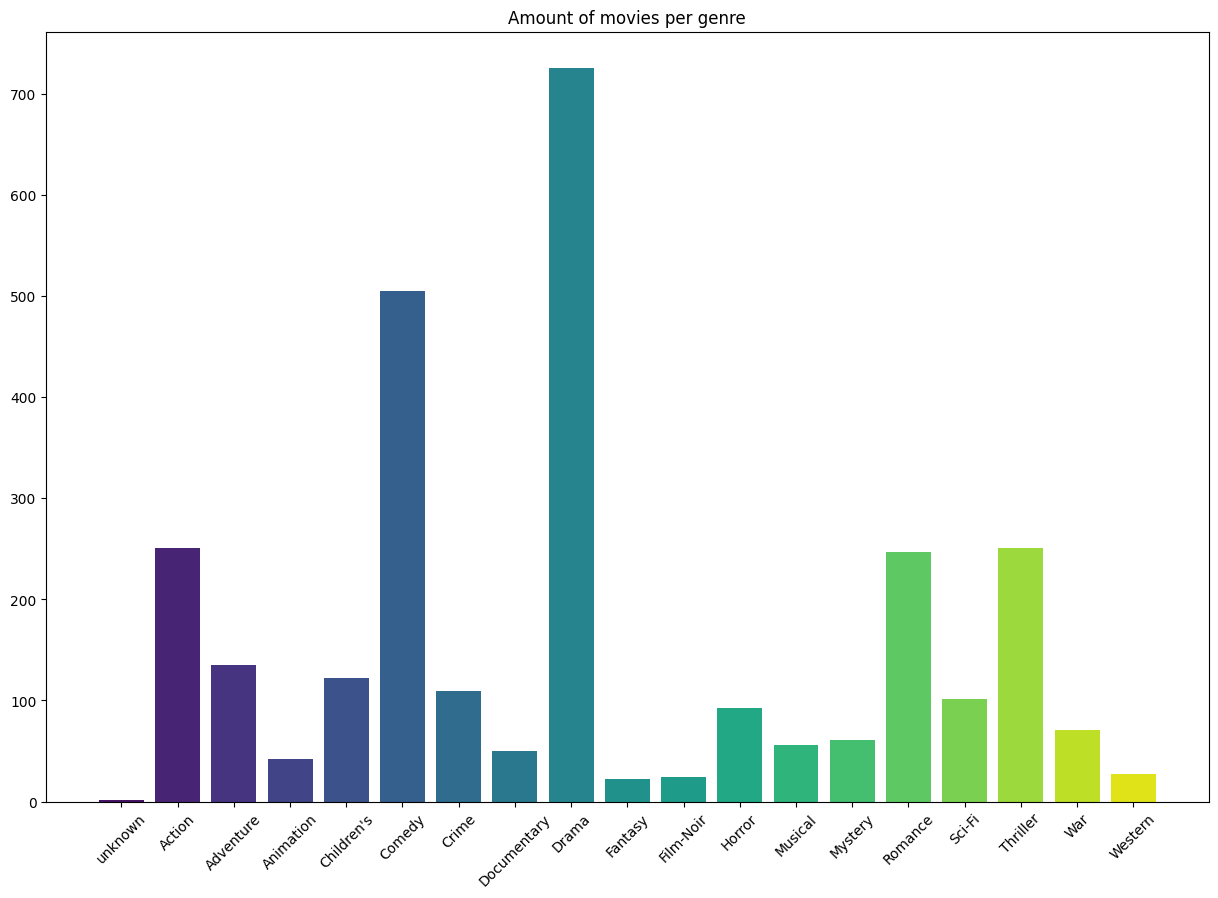

In [64]:
genre_count = {}
for genre in movie_items.columns[5:].to_list():
    genre_count[genre] = movie_items.value_counts(genre).iloc[1]



fig, ax = plt.subplots(figsize=(15,10))

colors = sns.color_palette('viridis', len(genre_count))

ax.bar(genre_count.keys(), genre_count.values(), color=colors)
ax.set_title('Amount of movies per genre')

plt.xticks(rotation=45)
plt.show()

### User Info

In [12]:
user_info.age.describe()

count     943
unique     61
top        30
freq       39
Name: age, dtype: object

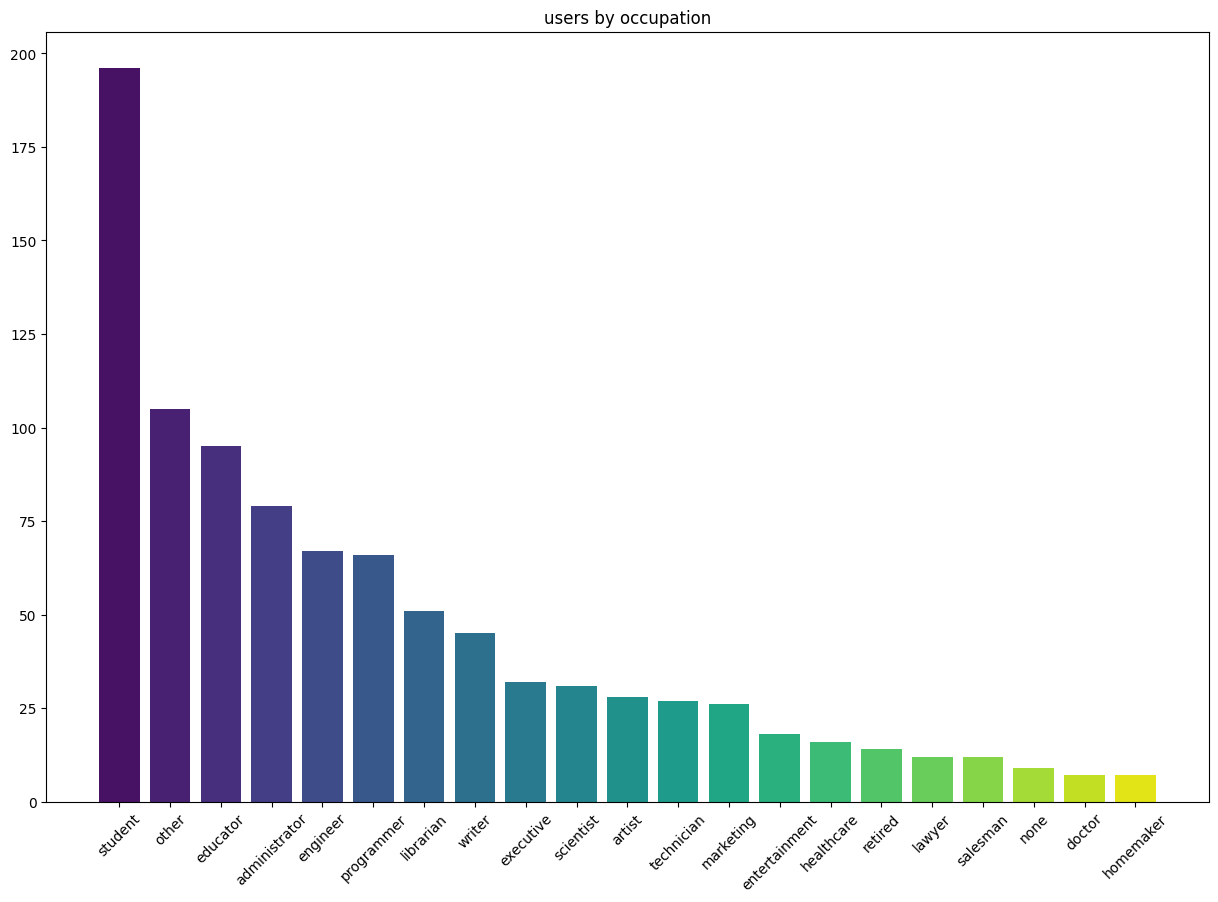

In [87]:
ocs = user_info.value_counts('occupation').to_dict()


fig, ax = plt.subplots(figsize=(15,10))

colors = sns.color_palette('viridis', len(ocs))

ax.bar(ocs.keys(), ocs.values(), color=colors)
ax.set_title('users by occupation')

plt.xticks(rotation=45)
plt.show()

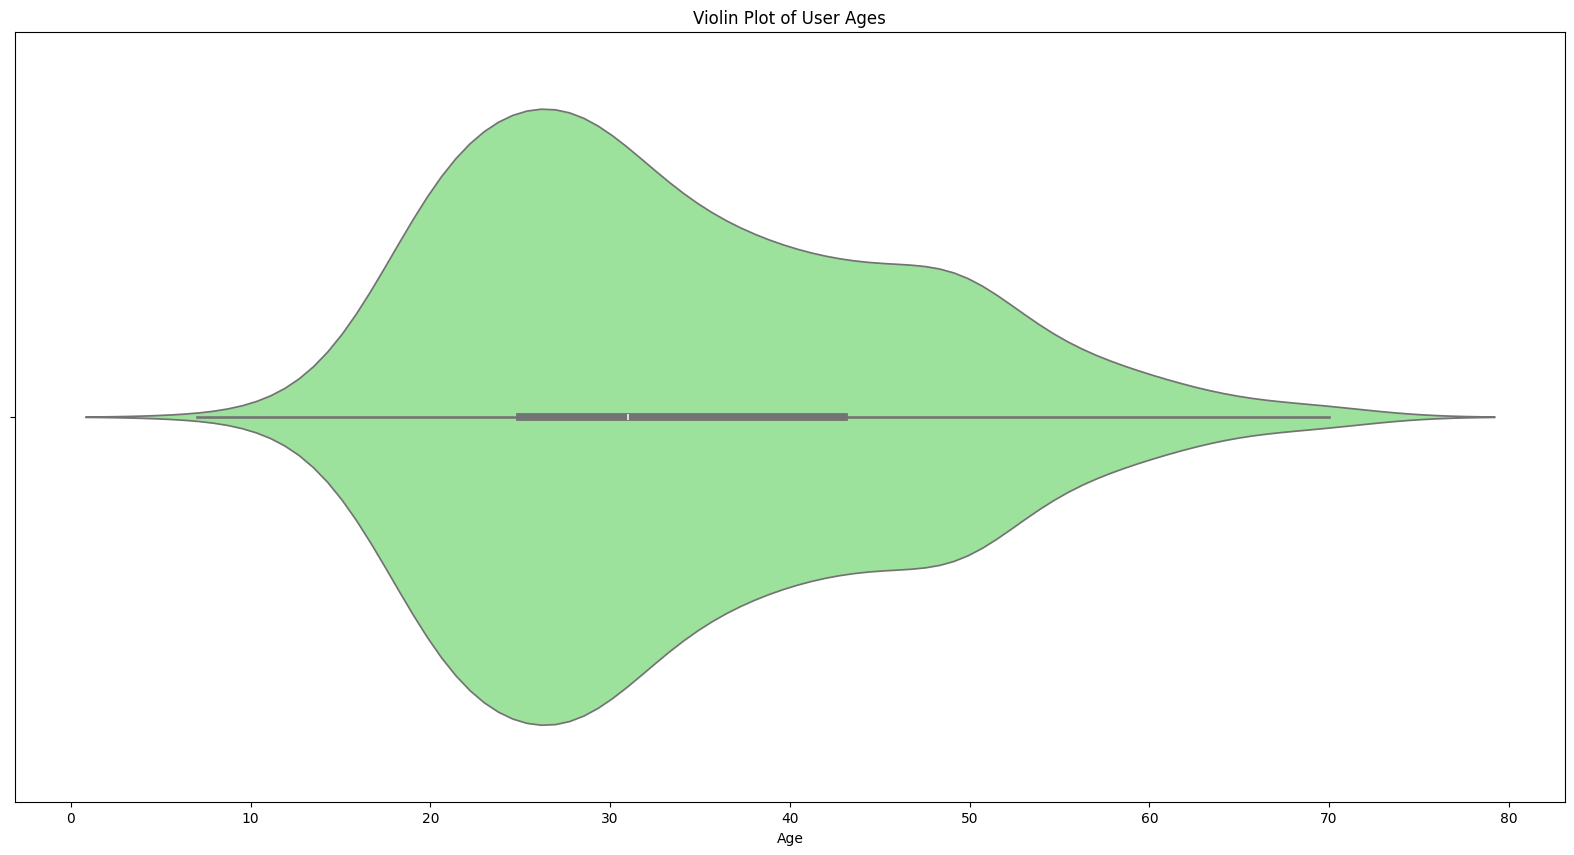

In [105]:

plt.figure(figsize=(20, 10))
sns.violinplot(data=user_info,x='age', color='lightgreen')
plt.title('Violin Plot of User Ages')
plt.xlabel('Age')
plt.show()


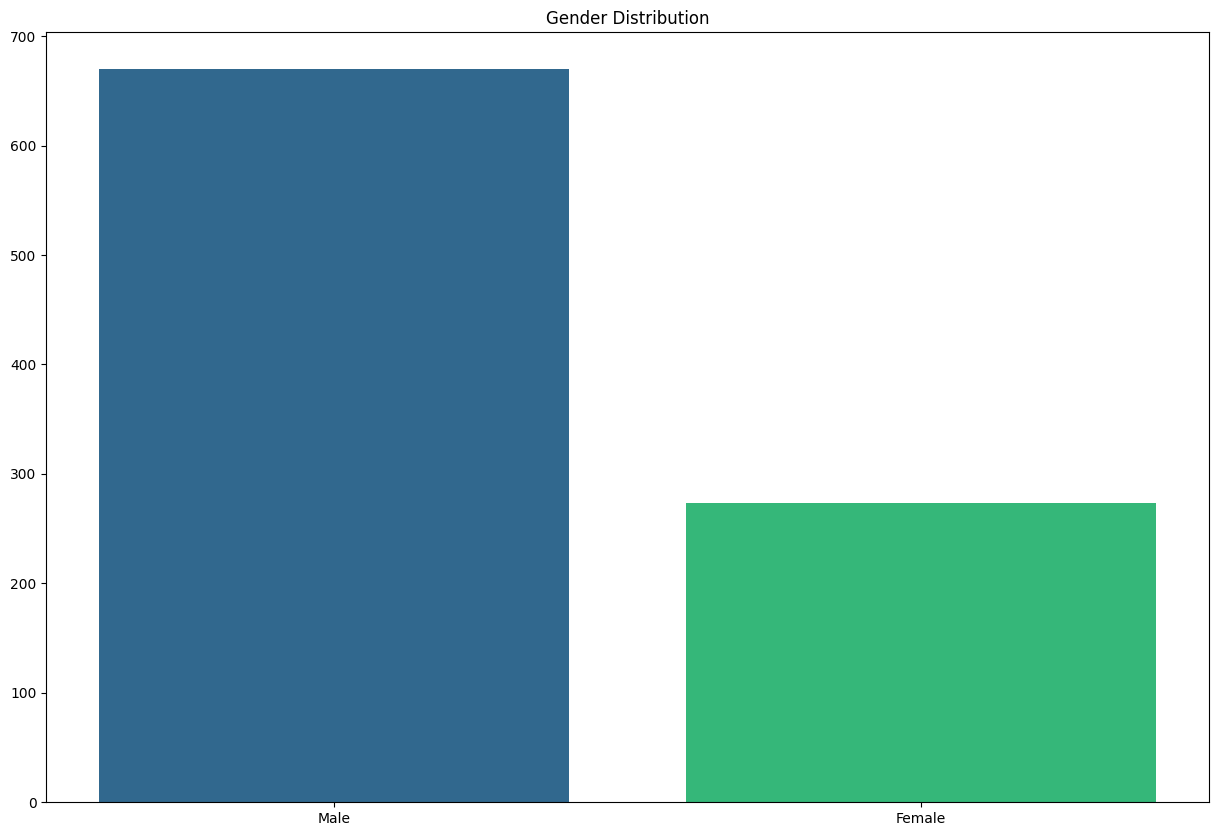

In [15]:
gender = user_info.value_counts('gender').to_dict()
fig, ax = plt.subplots(figsize=(15,10))

colors = sns.color_palette('viridis', len(gender))

ax.bar(['Male','Female'], gender.values(), color=colors)
ax.set_title('Gender Distribution')

plt.show()

In [159]:
from sklearn.cluster import KMeans

In [160]:
kmeans = KMeans(n_clusters=10)

In [87]:
genres = movie_items.columns[5:].to_list()

u = pd.merge(data_ratings,movie_items,on="Item ID",)
u = u.drop(columns=['movie_name','release_date', 'video_release_date','imdb_url','Timestamp'])

w= u.groupby('User ID')[genres].sum().reset_index()
w =pd.merge(w,user_info, on='User ID').drop(columns=['zip_code'])

In [92]:
cw = w
w

,User ID,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation
0,1,1,69,38,10,21,75,22,5,90,...,11,4,36,39,46,24,6,24,M,technician
1,2,0,10,2,1,3,16,8,0,29,...,0,3,13,4,10,2,0,53,F,other
2,3,0,13,4,0,0,11,8,1,19,...,2,11,5,7,20,5,0,23,M,writer
3,4,0,6,3,0,0,2,4,0,6,...,0,5,3,5,9,2,0,24,M,technician
4,5,1,49,28,13,25,72,8,0,24,...,11,3,17,28,19,13,2,33,F,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,914,0,0,0,0,0,1,0,0,1,...,0,0,2,0,0,0,0,44,F,other
912,916,0,2,1,0,0,3,1,0,4,...,1,0,1,1,2,1,2,27,M,engineer
913,918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,40,M,scientist
914,919,0,0,0,0,0,1,0,0,2,...,0,1,0,0,0,0,0,25,M,other


In [118]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [90]:
def one_over_n_hot(data,cat):
    one_hot = OneHotEncoder()

    div = 1/len(cat)
    one_hot.fit(cat)
    res = one_hot.transform(data)
    res = res * div
    return res
    

In [151]:
# Create OneHotEncoder instance
h_enc = OneHotEncoder(sparse=False)

# Fit and transform the 'occupation' column
occupation_encoded = one_hot_encoder.fit_transform(df[['occupation']])

# Create a DataFrame with the new one-hot encoded columns
occupation_encoded_df = pd.DataFrame(occupation_encoded, 
                                     columns=one_hot_encoder.get_feature_names_out(['occupation']))

# Concatenate the new columns to the original DataFrame
df = pd.concat([df, occupation_encoded_df], axis=1)

# Optionally, drop the original 'occupation' column
df.drop('occupation', axis=1, inplace=True)

# Show the updated DataFrame
print(df.head())


In [158]:
h_enc.fit(occupation)
enc_oc = h_enc.transform(cw[['occupation']])
temp = pd.DataFrame(enc_oc, columns=h_enc.get_feature_names_out(['occupation']))
cw = pd.concat([cw, temp], axis=1)
cw.drop('occupation', axis=1, inplace=True)
print(cw.head())

   User ID  unknown  Action  Adventure  Animation  Children's  Comedy  Crime  \
0        1        1      69         38         10          21      75     22   
1        2        0      10          2          1           3      16      8   
2        3        0      13          4          0           0      11      8   
3        4        0       6          3          0           0       2      4   
4        5        1      49         28         13          25      72      8   

   Documentary  Drama  ...  occupation_marketing  occupation_none  \
0            5     90  ...                   0.0              0.0   
1            0     29  ...                   0.0              0.0   
2            1     19  ...                   0.0              0.0   
3            0      6  ...                   0.0              0.0   
4            0     24  ...                   0.0              0.0   

   occupation_other  occupation_programmer  occupation_retired  \
0               0.0                   

In [163]:
res = kmeans.fit_transform(cw)

In [162]:
from sklearn.decomposition import PCA

In [173]:
red = PCA(n_components=2).fit_transform(res)

In [180]:
kmeans.score(cw)

-2783011.3058005753

## Desarrollo del sistema de Clasificacion

Ahora que ya se ha analizado la data, se procederá a implementar el sistema de recomendación de películas basado en factorización no negativa de matrices a través de la libreria scikit learn de Python

Para ello se importará la clase NMF y para evaluar su rendimiento se usará el error cuadrado medio o mean squared error (MSE)

In [7]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Importadas las librería, antes de pasar directamente a entrenar el modelo con la data es importante notar lo siguiente: 

Como se vió en el análisis de los datos, no todos los usuarios han califcado todas las películas o lo que es lo mismo, no todas las películas tienen calificaciones de cada usuario.
Esto presenta un caso muy común en la vida real, donde una persona  no mira cada película existente ni brinda una calificación sobre ella, lo que hace parecer que los datos estan incompletos, dificultando la predicción de los mismos. 

Para circunventar esta situación, se realizará lo siguiente: Se modificaran los datos para que que exista una relación entre cada usuario y cada película, en los casos donde el usuario no ha agregado una valoación para dicho film, se le asiganará el valor de 0, sin embargo esto tendrá como efecto secundario que la matriz se encontrarpa compuesta por una gran cantidad de ceros, los que serán mayoría en la matriz. A esto, se le conoce como matrix dispersa debido a la gran cantidad de valores cero o nulos que una matriz posee y pueden llegar a aumentar el tiempo de cálculo de la misma. 

Para evitar overfitting a la data, se dividirá en dos sets de datos, uno de entrenamiento y uno de test, para luego medir su rendimiento a través de MSE. 

Función que creará la matriz de datos completos, uniendo películas no calificadas por los usuarios con estos mismos y asignando 0 a la celda correspondiente: 

In [16]:
# Function that converts a matrix with data into a sparse matrix
def create_matrix(data,row,col):
    return data.pivot_table(columns=col, index=col, values='Rating', fill_value=0)

Ahora, se crearan los sets de entrenamiento y de prueba del sistema de recomendación: 

In [10]:
data = create_matrix(data_ratings['Rating'], data_ratings['User ID'],data_ratings['Item ID'])
train_data, test_data = train_test_split(data, test_size=0.3)

Una vez se han creado los datasets, se creará la función que servirá como sistema de recomendación. 

Para esto, se definirán los siguientes paramétros: 
* *n_components* que indicara la cantidad de componentes k en los cuales se dividirá la matriz $V$
* *tol* que indica la tolerancia del error en la medición como condición de paro para el algoritmo
* *max_iters*, la cantidad máxima de iteraciones que ejecutará la instancia de NMF antes de detenese como condición de paro en caso de que no se llegue a la tolerancia deseada
* *init* el método de inicialización del algoritmo, que por defecto será *random*

El resultado de está función será el siguiente: 
* **pdR** Un dataframe de pandas con la reconstrucción de la matriz $V$
* **W** la matriz de componentes o basis
* **H** la matriz de pesos
* **error** El valor de MSE entre la matriz de datos originales y la reconstrucción. 

In [11]:
def recommendation_system(data,n_components=5, max_iters=200, tol=0.1, init='random'):

    # Creating the instance of NMF 
    nmf = NMF(n_components=n_components, init=init, max_iter=max_iters)
    # training the model and obtaining W and H matrices
    W = nmf.fit_transform(data)
    H = nmf.components_
    R = np.dot(W,H) #Reconstruction matrix
    pdR = pd.DataFrame(R) # more readable reconstruction matrix
    
    error = mean_squared_error(data,R) # MSE between original matrix and reconstruction
    return [pdR,W,H,error]


Ahora que ya se ha creado el sistema de recomendación, se procedera a ejecutarlo con la data que se ha revisado, relacionada a ratings de películas. 

Para la cantidad de componentes K, se usarán las agrupaciones previamente encontradas en el análisis de datos y también valores como la cantidad de genéros de películas, tomando aquel que obtenga el mejor resultado de ellos para las predicciones. 

Cabe notar que no se buscará una reconstrucción exacta de la matriz inicial, no solo por la dificultad de esto, si no por el hecho de que la reconstrucción imperfecta que llenará valores no previamente calificados permitirá desarrollar las recomendaciones para los usuarios. 

In [12]:
result = recommendation_system(data,n_components=19)

D:\Progra\Python\ML Projects\ml\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [13]:
print(result[0])

         0         1         2         3         4         5         6     \
0    4.294375  1.684542  0.800010  2.158221  0.691852  0.233123  4.207049   
1    2.556605  0.015177  0.165511  0.044374  0.131398  0.229656  1.281047   
2    0.225987  0.017556  0.020990  0.121368  0.005423  0.016362  0.059728   
3    0.475345  0.000183  0.028625  0.071565  0.044960  0.018305  0.222979   
4    3.327127  0.657221  0.389053  1.319068  0.616895  0.000780  2.165936   
..        ...       ...       ...       ...       ...       ...       ...   
916  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
917  0.001915  0.000000  0.000414  0.004222  0.000000  0.005640  0.006660   
918  0.004861  0.000925  0.001630  0.005374  0.001780  0.007629  0.010449   
919  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
920  0.037293  0.018859  0.028033  0.018649  0.009809  0.000316  0.051657   

         7         8         9     ...      1659      1660      1661  \
0  

El error obtenido es:

In [14]:
print(result[-1])

0.35791691939859027


Calculada la matriz de reconstrucción, se compararan ambas matrices de forma general y luego tomando a un usuario en específico para ver como han cambiado los datos de forma más granularizada: 

El cambio más claro a nivel global es que la reconstrucción no es perfecta, algo esperado dada la naturaleza del método y el hecho de que el error obtenido es diferente de 0. 
Partiendo de esto, se puede observar que muchos de los valores que anteriormente eran 0 pasaron a contener algún grado de variación o promedio, acorde a las modificaciones introducidas por los pesos obtenidos en la matriz de H, y como al recalcular las celdas a traves de las combinaciones lineales estas se vieron afectadas, lo que permitirá establecer si un usuario en especifico podría interesarse en dicho film que no ha visto o calificado basandosé en el resto de usuarios. 

Veamos un usuario en especifíco: 

In [15]:
user = [data[:1],result[0][:1]]
user[0]

,0,1,2,3,4,5,6,7,8,9,...,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668
0,5,3,0,3,3,5,0,1,5,3,...,0,0,0,0,0,0,0,0,0,0


In [16]:
user[1]

,0,1,2,3,4,5,6,7,8,9,...,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668
0,4.294375,1.684542,0.80001,2.158221,0.691852,0.233123,4.207049,1.760165,2.5043,1.001491,...,0.006015,0.003049,0.001155,0.0,0.002014,0.0,0.0,0.0,0.0,0.0


Análisis:

**¿Cómo puedo evaluar que peliculas le podrian gustar a un usuario nuevo (que no este en la base de datos) basado en las calificaciones que este da a una serie de peliculas?**

Al ingresar el usuario la información de los ratings dados a una serie de películas presentadas para poder tomarlas de indicador, se obtiene información que permite ser ingresada
en el sistema de recomendaciones y recalcular que otras películas que no haya visto o calificado podrían interesarle.

Esto podra realizarse gracias a que el sistema de recomendación de forma implícita, crea una serie de perfiles con características especificadas basadas en la descomposición de la matriz original. 
Al brindar información acerca de sus gustos, se puede incluir en alguno de los perfiles obtenidos a través de NMF; que si bien no encajará a la perfección, si compartirá similitudes. 
Es de estas similitudes donde se puede evaluar que otras peliculas podrían gustarle en base a los valores dados por otros usuarios pertenecientes al perfil asignado al nuevo usuario. 

A esto se le conoce como collaborative filtering, donde se llevan a cabo recomendaciones de contenido a partir de los múltiples valores previamente dados por muchos usuarios y permite trabajar bajo
la premisa de que si usuarios como Juan y Timothy tienen gustos similares y existe una película que Juan ha visto y le gusto y Timothy no la ha visto, es muy probable que si se le recomienda a este último que la vea, es muy posible que le termine gustando dado que sus gustos son parecidos a Juan. 

Análisis sobre como incorporar toda la información otorgada.


# Testing Zone

In [7]:
pdata = create_matrix(data_ratings['Rating'], data_ratings['User ID'],data_ratings['Item ID'])

print(pdata)

     0     1     2     3     4     5     6     7     8     9     ...  1659  \
0       5     3     0     3     3     5     0     1     5     3  ...     0   
1       4     0     0     0     0     0     0     0     0     2  ...     0   
2       0     0     0     0     0     0     0     0     0     0  ...     0   
3       0     0     0     0     0     0     0     0     0     0  ...     0   
4       4     3     0     0     0     0     0     0     0     0  ...     0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
916     0     0     0     0     0     0     0     0     0     0  ...     0   
917     0     0     0     0     0     0     0     0     0     0  ...     0   
918     0     0     0     0     0     0     0     0     0     0  ...     0   
919     0     0     0     0     0     0     0     0     0     0  ...     0   
920     0     0     0     0     0     0     0     0     0     0  ...     0   

     1660  1661  1662  1663  1664  1665  1666  1667  1668  
0  

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [13]:
nmf = NMF(n_components=19,init='random', max_iter=500)
W = nmf.fit_transform(pdata)
H =  nmf.components_